# Descripción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

# Plan de trabajo

**1. Cargar y preparar los datos:**

-Combinar todas las tablas contract.csv, personal.csv, internet.csv y phone.csv usando la columna customerID como clave principal.

-Limpiar los datos: manejar valores ausentes, duplicados y errores.

-Crear nuevas características, si es necesario.

-Realizar un resumen estadistico de las variables

**2. Análisis exploratorio de datos (EDA):**

-Visualizar la distribución de la variable objetivo.

-Revisar correlación de las variables.

-Revisar comportamiento de las variables categóricas.

-Análisis de las inicializaciones y cancelaciones de contrato.

**3. Ajuste y división de los datos:** 

-Dividir los datos en conjuntos de entrenamiento, validación y prueba

-Codificar las variables categóricas.

-Escalar las variables numéricas.

-Balancear las clases

**4. Entrenar y ajustar modelos:**

-Entrenar al menos tres modelos de clasificación, como: regresión logística, árbol de decisión, bosque aleatorio, algun modelo basado en potenciación del gradiente (LightGBM, XGBoost o CatBoost).

-Usa GridSearchCV o RandomizedSearchCV para optimizar los hiperparámetros.

**5. Evaluar y comparar los modelos:**

-Usar métricas como F1-score, AUC-ROC para evaluar los modelos.

-Escoger el mejor modelo en función de las métricas y prueba de su rendimiento en el conjunto de prueba.


## Inicialización

In [1]:
# Cargar las librerias
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# Cargar los datos
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Preparación de los datos

In [3]:
# Validar las dimensiones de cada  dataframe 
for data in [contract, personal, internet, phone]:
  print(data.shape)

(7043, 8)
(7043, 5)
(5517, 8)
(6361, 2)


In [4]:
# Mostrar las primeras filas de cada conjunto de datos
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [8]:
# Validar informacion general de cada conjunto de datos
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [12]:
# Fusionar todos los datos en una sola tabla
df = contract.merge(personal, on='customerID', how='left') \
               .merge(internet, on='customerID', how='left') \
               .merge(phone, on='customerID', how='left')

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
#mostrar informacion del nuevo dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Corrección de los datos

In [14]:
# Cambiar nombres de columnas para que se vean de una forma mas uniforme

# crear una lista con los nombres correctos
new_columns = ['customer_id','begin_date', 'end_date', 'type', 
               'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 
               'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# Asignar los nuevos nombres de columnas
df.columns = new_columns

#Validar los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [15]:
# Convertir la columna 'begin_date' a tipo datetime64[ns]
df['begin_date'] = pd.to_datetime(df['begin_date'], errors='coerce')

In [16]:
# Verificar si hay valores no numéricos en la columna total_charges
df['total_charges'].value_counts().sort_values()

2405.05     1
4896.35     1
6129.65     1
1249.25     1
679.8       1
           ..
19.9        8
20.05       8
19.75       9
           11
20.2       11
Name: total_charges, Length: 6531, dtype: int64

In [17]:
# Filtrar filas donde la columna 'total_charges' contiene un espacio en blanco 
df[df['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Se procederá a eliminar las filas que contienen valores con espacios en blanco, ya que son un total de 11 registros. Dado que estos valores son mínimos, no afectarán significativamente la eficacia del modelo

In [18]:
# Reemplazar los valores con espacio en blanco (' ') por NaN
df['total_charges'] = df['total_charges'].replace(' ', pd.NA)

# Eliminar las filas con NaN en la columna 'total_charges'
df = df.dropna(subset=['total_charges'])

# Convertir la columna 'total_charges' a tipo float
df['total_charges'] = df['total_charges'].astype(float)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   5512 non-null   object        
 13  online_security    5512 non-null   object        
 14  online_b

### Duplicados y valores ausentes

In [20]:
#Validar valores duplicados
df.duplicated().sum()

0

In [21]:
#Validar valores ausentes
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

In [22]:
# Revisar valores unicos en la columna internet_service
df['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [23]:
# Rellenar los valores ausentes de la columna internet_service por 'none'
df['internet_service'].fillna('none', inplace= True)

#verificar los cambios
df['internet_service'].isna().sum()

0

In [24]:
# Rellenar los valores ausentes de las demas columnas por el valor de 0
df.fillna(0, inplace= True)

#Validar los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

Se procederá a cambiar varias columnas con valores 'Yes' y 'No' por valores numéricos: 1 para 'Yes' y 0 para 'No'.

In [25]:
# Lista de columnas con valores 'Yes' y 'No'
yn_columns = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup',
              'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# Reemplazar 'Yes' por 1, 'No' por 0 
df[yn_columns] = df[yn_columns].replace({'Yes': 1, 'No': 0})


# Asegurarse que las columnas son de tipo entero
df[yn_columns] = df[yn_columns].astype('int')


In [26]:
# Validar los cambios y mostrar algunos datos del dataframe
df.info()

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   int64         
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   int64         
 11  dependents         7032 non-null   int64         
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   int64         
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
476,3780-DDGSE,2017-03-01,No,Month-to-month,1,Electronic check,76.05,2747.20,Male,1,1,1,DSL,0,1,0,1,1,1,0
5556,5364-EVNIB,2018-12-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,79.80,973.45,Male,0,0,0,Fiber optic,0,1,1,0,0,0,0
3439,0917-EZOLA,2013-10-01,2019-10-01 00:00:00,Two year,1,Bank transfer (automatic),104.15,7689.95,Male,1,1,0,Fiber optic,0,1,1,0,1,1,1
4529,0423-UDIJQ,2019-05-01,No,Month-to-month,0,Mailed check,49.20,447.90,Male,1,0,0,DSL,0,0,0,1,0,0,0
5208,6502-KUGLL,2018-12-01,No,Month-to-month,0,Bank transfer (automatic),59.45,780.85,Female,0,1,1,DSL,1,1,0,1,0,0,0


In [27]:
#crear la columna objetivo (churn) a partir de la columna end_date
df['churn'] = (df['end_date'] != 'No').astype('int')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,Female,0,...,0,DSL,0,1,0,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,Male,0,...,0,DSL,1,0,1,0,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,Male,0,...,0,DSL,1,1,0,0,0,0,0,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,...,0,DSL,1,0,1,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,Female,0,...,0,Fiber optic,0,0,0,0,0,0,0,1


### Resumen de las variables numericas

In [28]:
# Estadisticas de las variables numericas
df[['monthly_charges','total_charges']].describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


### Resumen de las variables categóricas

In [29]:
# Estadisticas de las variables categóricas
df[['type','payment_method', 'gender', 'internet_service']].describe()

,type,payment_method,gender,internet_service
count,7032,7032,7032,7032
unique,3,4,2,3
top,Month-to-month,Electronic check,Male,Fiber optic
freq,3875,2365,3549,3096


### Resumen de las variables con fechas

In [30]:
# Estadisticas de las variables con fechas
df['begin_date'].describe(datetime_is_numeric=True)
     

count                             7032
mean     2017-04-28 23:14:44.641638400
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: begin_date, dtype: object

In [31]:
# Verificar si las fechas estan en orden ascendente
df['begin_date'].is_monotonic_increasing

False

In [32]:
# Ordenar las fechas en orden ascendente
df = df.sort_values('begin_date') 

Se observa que las fechas de inicio de los contratos abarcan desde el año 2013 hasta el año 2020.

In [33]:
# Filtrar usuarios que han finalizado su contrato
df_end_date = df[df['end_date'] != 'No'].copy()

# Convertir la columna 'end_date' a tipo datetime para facilitar su análisis
df_end_date['end_date'] = pd.to_datetime(df_end_date['end_date'])
     

# Estadisticas de la columna end_date
df_end_date['end_date'].describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630720
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object

Se observa que las fechas de terminación de los contratos oscilan entre 2019 y 2020, lo que indica que los clientes comenzaron a cancelar sus servicios en los últimos años.

## Análisis exploratorio de datos

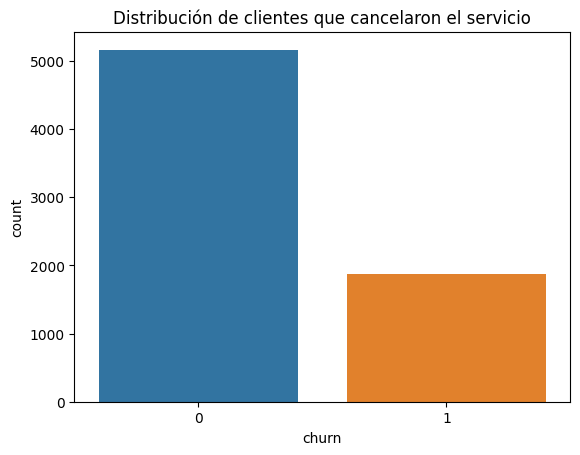

In [34]:
# Visualizar la columna objetivo (churn)
sns.countplot(data=df, x='churn') 
plt.title('Distribución de clientes que cancelaron el servicio')
plt.show()

In [35]:
# Proporción de los valores
df['churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: churn, dtype: float64

Como se muestra en el gráfico, se puede observar que el 26.57% de los usuarios han cancelado el servicio

### Correlación de las variables

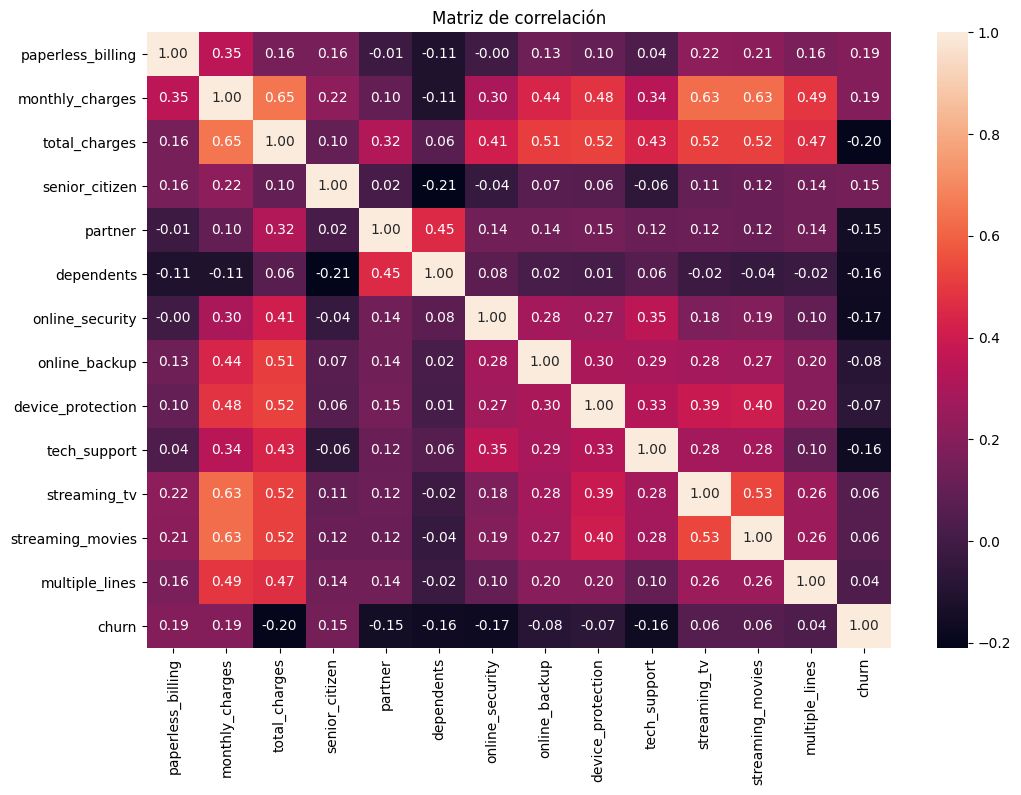

In [36]:
# Correlación entre variables

plt.figure(figsize=(12, 8)) # Ajustar el tamaño de la figura

sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Vemos que las variables con mayor correlacion con la columna objetivo (churn) son: total_charges, monthly_charges, paperless_billing. 

En total_charges hay una correlación de -0.2, lo que sugiere una relación débil negativa entre el total de cargos y la cancelación del servicio. Es decir, los clientes con mayores cargos totales tienen una ligera tendencia a no cancelar el servicio. Aunque la correlación es baja, puede ser útil, especialmente en modelos predictivos, ya que refleja la duración de la relación con el cliente.

En monthly_charges la correlación es de 0.19, una correlación positiva débil entre los cargos mensuales y la cancelación. Esto podría indicar que los clientes con mayores cargos mensuales son ligeramente más propensos a cancelar el servicio.

En paperless_billing la correlación es de 0.19, esta variable muestra una correlación positiva débil con churn. Los clientes que usan la facturación electrónica tienen una ligera tendencia a cancelar el servicio, aunque no es una relación fuerte. 

las anteriores variables parecen tener una mayor influencia en la columna churn, aunque todas las correlaciones son débiles. Esto sugiere que, aunque algunos factores pueden estar relacionados con la cancelación del servicio, no existe una relación fuerte y única.

### Relación entre las variables categóricas y la variable objetivo

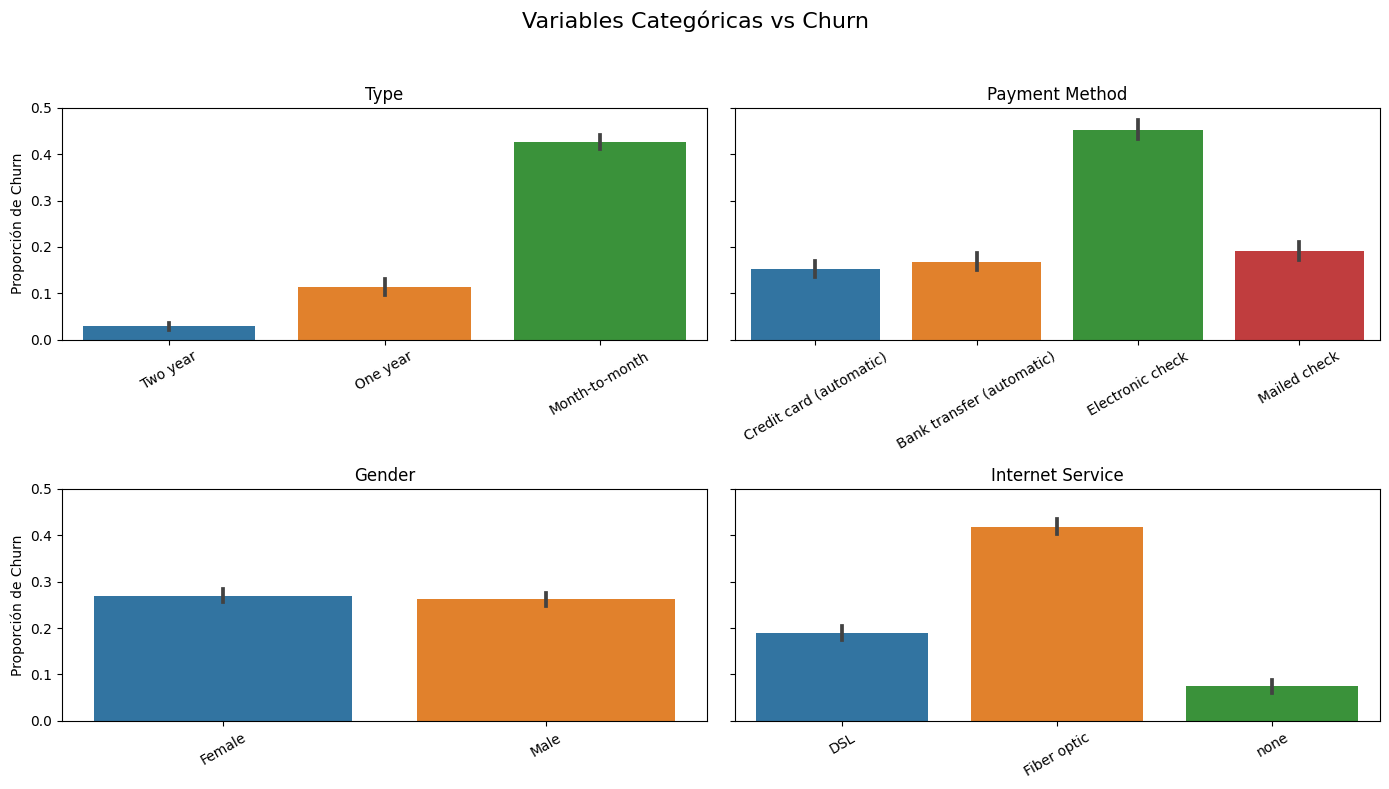

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
fig.suptitle('Variables Categóricas vs Churn', fontsize=16)

# Gráficos de barras
sns.barplot(ax=axes[0, 0], data=df, x='type', y='churn')
axes[0, 0].set_title('Type')
axes[0, 0].set_ylabel('Proporción de Churn')

sns.barplot(ax=axes[0, 1], data=df, x='payment_method', y='churn')
axes[0, 1].set_title('Payment Method')
axes[0, 1].set_ylabel('')

sns.barplot(ax=axes[1, 0], data=df, x='gender', y='churn')
axes[1, 0].set_title('Gender')
axes[1, 0].set_ylabel('Proporción de Churn')

sns.barplot(ax=axes[1, 1], data=df, x='internet_service', y='churn')
axes[1, 1].set_title('Internet Service')
axes[1, 1].set_ylabel('')

# Ajustar etiquetas
for ax in axes.flat:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)
plt.ylim(0, 0.5)  # Asegurar consistencia en el eje Y
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar espacio para el título
plt.show()


Según las gráficas, se observa que en cuanto al tipo de pago, los clientes con contratos de 1 o 2 años presentan la menor proporción de cancelación del servicio.

En el caso del método de pago, los clientes que pagan mediante cheque electrónico tienen la mayor proporción de cancelación del servicio, mientras que los demás métodos de pago mantienen proporciones similares.

Respecto al género, no se evidencia una diferencia significativa; la tasa de cancelación del servicio es similar tanto para hombres como para mujeres.

En cuanto al servicio de internet, los clientes que cuentan con fibra óptica presentan la mayor proporción de cancelación, con el doble de cancelaciones que los clientes que utilizan el servicio DSL.

### Análisis de las inicializaciones y cancelaciones de contrato

#### Inicializaciones de contrato

In [38]:
# Configurar begin_date como indice
df.set_index(keys='begin_date', inplace= True)
df_begin_date = df.copy() 

# Validar que las fechas estan en orden ascendente
df_begin_date.index.is_monotonic_increasing

True

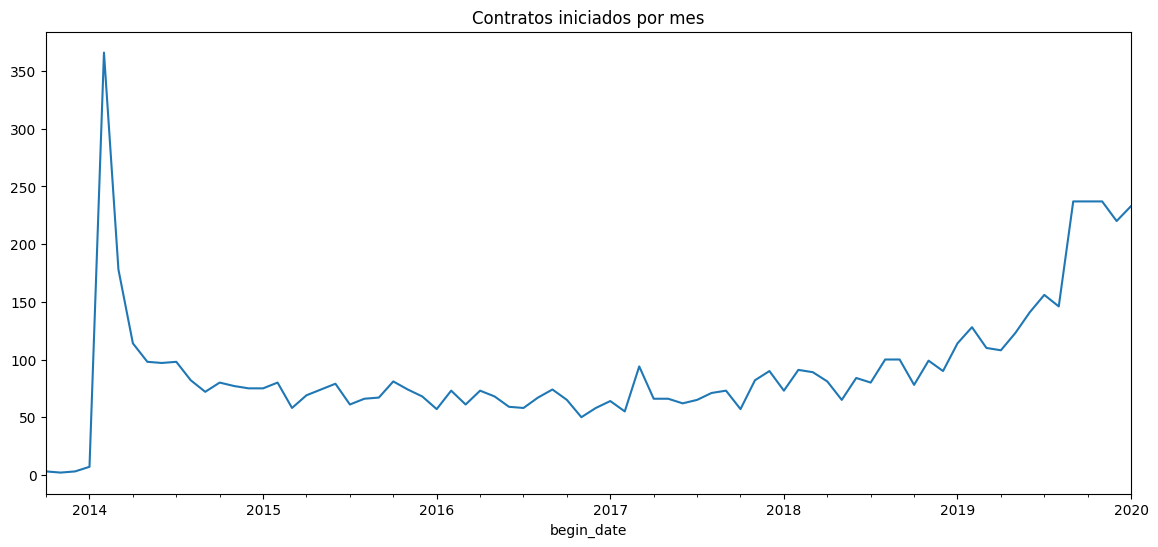

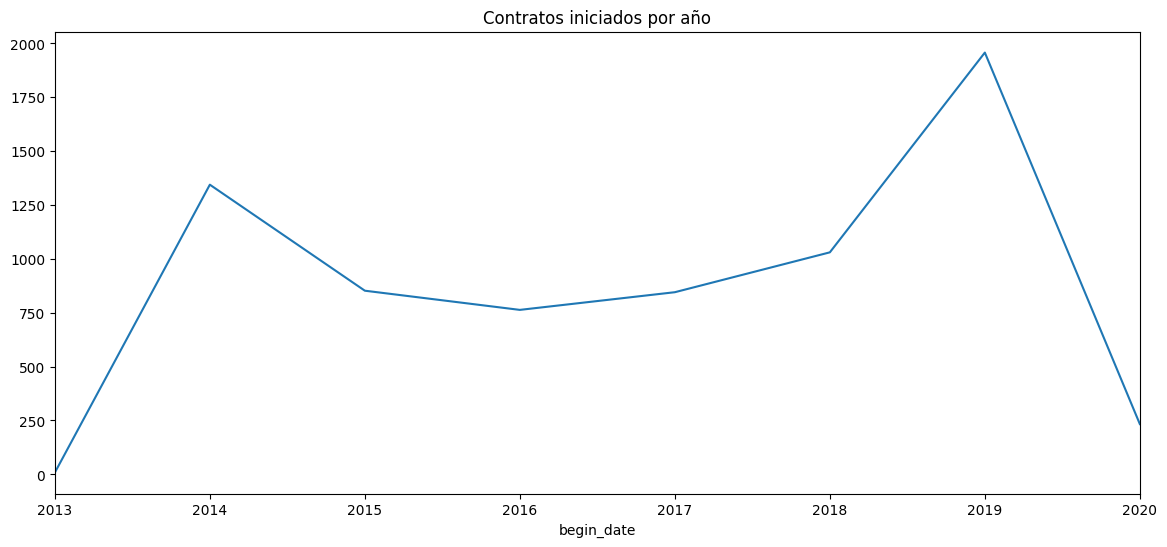

In [39]:
# Cantidad de contratos iniciados por mes
df_begin_date.resample('1M')['churn'].count().plot(figsize=(14,6))
plt.title('Contratos iniciados por mes')
plt.show()


# Cantidad de contratos iniciados por año
df_begin_date.resample('1Y')['churn'].count().plot(figsize=(14,6))
plt.title('Contratos iniciados por año')
plt.show()
     

Al observar los contratos iniciados por año, se destaca un incremento significativo en 2014, que podría reflejar una fuerte captación de nuevos clientes. Sin embargo, después de 2014, la cantidad de contratos experimenta una disminución gradual hasta 2016-2017. En 2018 y 2019, se observa un crecimiento en la cantidad de contratos iniciados, con 2019 siendo el año de mayor crecimiento. Este aumento podría estar asociado con nuevas ofertas o campañas comerciales. No obstante, en 2020, se experimenta una caída drástica, con solo 233 contratos.

#### Cancelaciones de contrato

In [40]:
# Configurar end_date como indice
df_end_date1 = df_end_date.set_index('end_date')

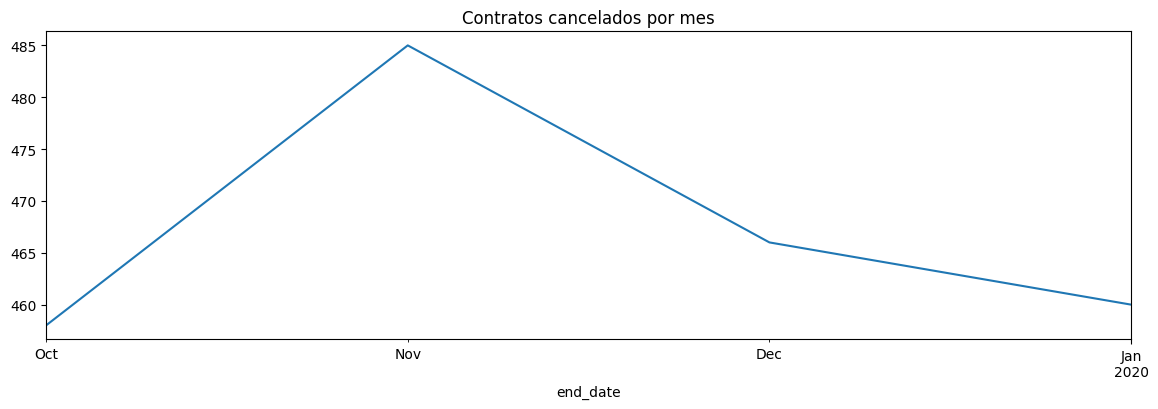

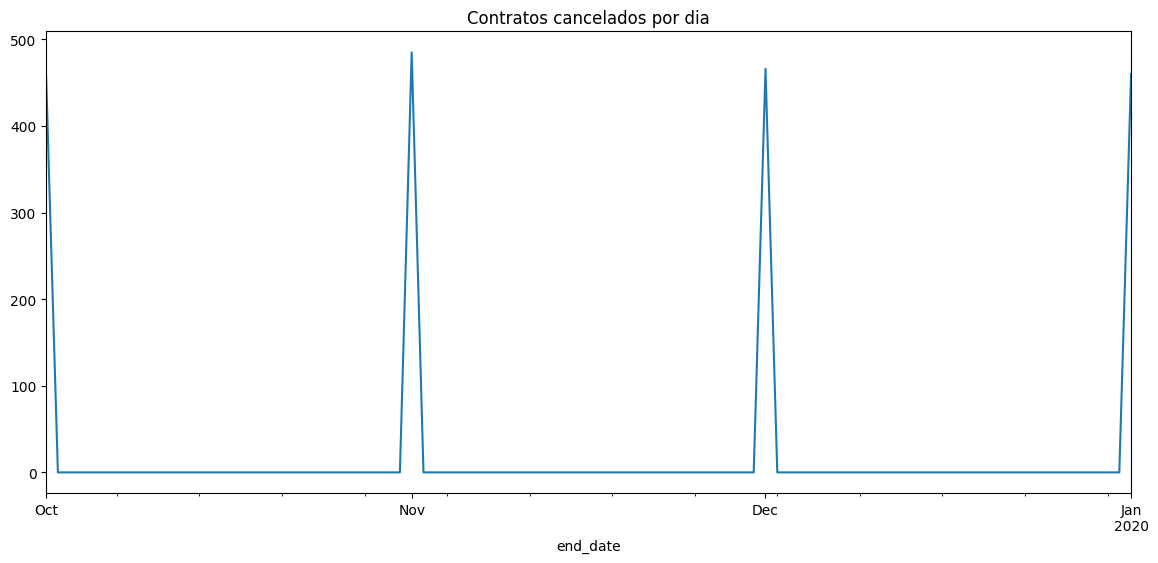

In [41]:
# Cantidad de contratos cancelados por mes
df_end_date1.resample('1M')['churn'].sum().plot(figsize=(14,4))
plt.title('Contratos cancelados por mes')
plt.show()

# Cantidad de contratos cancelados por dia
df_end_date1.resample('1D')['churn'].sum().plot(figsize=(14,6))
plt.title('Contratos cancelados por dia')

plt.show()

Al observar los datos agrupados por mes, se evidencia que las cancelaciones se mantienen bastante estables, con un leve descenso en los últimos meses de 2019. Esto podría sugerir una tendencia estable a lo largo del tiempo.

En cuanto a los datos diarios, se evidencia que las cancelaciones ocurren de manera puntual en fechas específicas, como al inicio de cada mes. Esto podría indicar que el proceso de cancelación de contratos está concentrado en ciertas fechas.

## Preparación y división de los datos

Se validan las columnas que no seran relevantes para el entrenamiento del modelo, las cuales son: la columna customer_id, la columna gender que no muestra alguna influencia para nuestro objetivo, y la columna end_date ya que esta información se encuentra dentro de la columna objetivo (churn).

Por lo anterior se procedera a eliminar dichas columnas para una mejor preparación del modelo.

In [42]:
# Eliminar columnas que son irrelevantes
df = df.drop(['customer_id', 'gender', 'end_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7032 entries, 2013-10-01 to 2020-01-01
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   int64  
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   senior_citizen     7032 non-null   int64  
 6   partner            7032 non-null   int64  
 7   dependents         7032 non-null   int64  
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   int64  
 10  online_backup      7032 non-null   int64  
 11  device_protection  7032 non-null   int64  
 12  tech_support       7032 non-null   int64  
 13  streaming_tv       7032 non-null   int64  
 14  streaming_movies   7032 non-null   int64  
 15  multiple_lines     7032 non-null   int64  
 16  churn 

In [43]:
# Separar las caracteristicas y el objetivo
X = df.drop('churn', axis=1)
y = df['churn']

In [44]:
# Dividir los datos en conjunto de entrenamiento, validacion y prueba 

# Dividir el entrenamiento (60%) y un conjunto combinado de validación/prueba (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=12345, shuffle= False)

# Dividir el conjunto combinado (40%) en la mitad para obtener validacion 20% y prueba 20%
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=12345, shuffle= False)

### One-Hot Encoding

In [45]:
# Realizar One-Hot Encoding usando pd.get_dummies en las variables categóricas

# Primero, aplicamos One-Hot Encoding solo en X_train
X_train_ohe = pd.get_dummies(X_train, drop_first=True)

# Aplicar One-Hot Encoding a los conjuntos de validación y prueba, utilizando las mismas columnas
X_valid_ohe = pd.get_dummies(X_valid, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, drop_first=True)


### Escalado de datos

In [46]:
# Revisar las columnas numéricas
df[['monthly_charges','total_charges']].describe()  

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


Al observar la tabla la columna monthly_charges tiene un rango de valores entre 18.25 y 118.75, con una media de 64.79 y una desviación estándar de 30.08. Por otro lado, la columna total_charges varía entre 18.80 y 8684.80, con una media de 2283.30 y una desviación estándar de 2266.77.
Estas diferencias en las escalas  pueden generar un sesgo en los modelos de machine learning, ya que los algoritmos sensibles a la magnitud de los valores, pueden dar más peso a la variable total_charges debido a su mayor rango. Esto afectaría negativamente el rendimiento del modelo, ya que no se estarían considerando de forma equitativa ambas características.

Por lo tanto, es recomendable escalar ambas columnas para que tengan una escala similar, permitiendo que el modelo las trate de manera equilibrada.

In [47]:
# Función para estandarizar las características numéricas

def standardize_data(X_train, X_valid, X_test):
    # Crear el escalador
    scaler = StandardScaler()

    # Seleccionar solo las columnas numéricas
    numerical_columns = ['monthly_charges', 'total_charges']

    # Ajustar el escalador en los datos de entrenamiento y transformarlos
    X_train_scaled = X_train.copy()
    X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

    # Transformar los datos de validación y prueba usando el mismo escalador
    X_valid_scaled = X_valid.copy()
    X_valid_scaled[numerical_columns] = scaler.transform(X_valid[numerical_columns])

    X_test_scaled = X_test.copy()
    X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

    return X_train_scaled, X_valid_scaled, X_test_scaled

# Llamar a la función para estandarizar los datos
X_train_scaled, X_valid_scaled, X_test_scaled = standardize_data(X_train_ohe, X_valid_ohe, X_test_ohe)

# Verificar las características estandarizadas
print(X_train_scaled[['monthly_charges', 'total_charges']].describe())

       monthly_charges  total_charges
count     4.219000e+03   4.219000e+03
mean      2.020980e-16   1.616784e-16
std       1.000119e+00   1.000119e+00
min      -1.678776e+00  -1.474800e+00
25%      -8.054020e-01  -8.682096e-01
50%       2.753783e-01  -1.757644e-01
75%       8.303516e-01   7.821789e-01
max       1.578148e+00   2.403647e+00


### Balance de clases

In [48]:
# Función para balancear datos
def upsample(X, y):
    
    # Separar las respuestas del conjunto de datos de entrenamiento
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    # Calcular cuántas veces duplicar la clase minoritaria
    repeat = len(y_zeros) // len(y_ones)
    
    # Aumentar las observaciones de cancelaciones
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    
    
    # Reordenar los datos por índice para preservar el orden temporal
    X_upsampled.sort_index(inplace=True)
    y_upsampled.sort_index(inplace=True)
    
    return X_upsampled, y_upsampled

# Balancear datos de cancelaciones
X_train_balanced, y_train_balanced = upsample(X_train_scaled, y_train)

# Verificar el rango de fechas y el equilibrio de clases
print('Rango de fechas del conjunto de entrenamiento: ', X_train_balanced.index.min(), ' - ', X_train_balanced.index.max())
print('Rango de fechas del conjunto de validación: ', X_valid_scaled.index.min(), ' - ', X_valid_scaled.index.max())
print('Rango de fechas del conjunto de prueba: ', X_test_scaled.index.min(), ' - ', X_test_scaled.index.max())

# Verificar el equilibrio de clases
print(y_train_balanced.value_counts(normalize=True))

Rango de fechas del conjunto de entrenamiento:  2013-10-01 00:00:00  -  2018-06-01 00:00:00
Rango de fechas del conjunto de validación:  2018-06-01 00:00:00  -  2019-07-01 00:00:00
Rango de fechas del conjunto de prueba:  2019-07-01 00:00:00  -  2020-01-01 00:00:00
0    0.514866
1    0.485134
Name: churn, dtype: float64


Para preparar los datos para el modelo, se realizó One-Hot Encoding para convertir las variables categóricas en variables numéricas y evitar que el modelo asuma relaciones de orden entre ellas. Además, se aplicó un escalado de características para asegurarse de que las variables numéricas tuvieran escalas similares, evitando que las características con mayores rangos dominen el modelo. Finalmente, se llevó a cabo un balanceo de clases para corregir el desbalance entre las clases de la variable objetivo, duplicando las observaciones de la clase minoritaria y garantizando que el modelo tuviera la capacidad de predecir ambas clases de manera equitativa.

## Entrenamiento y ajustes de los modelos

In [49]:
# Crear función para evaluar diferentes modelos con datos de entrenamiento, validación y prueba

def evaluate_classifiers(X_train, y_train, X_valid, y_valid, X_test, y_test):
    
    # Definir los hiperparámetros para GridSearchCV
    
    param_grid_lr = {
        'solver': ['liblinear', 'newton-cg', 'saga'],
        'C': [0.1, 1, 10, 100] 
    }
    
    param_grid_dt = {
        'max_depth': [7, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
    }
    
    param_grid_rf = {
        'n_estimators': [10, 100, 150],
        'max_depth': [7, 10, 15, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    param_grid_lgbm = {
        'n_estimators': [60, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [4, 8, 10],
        'max_depth': [2, 5, 10, 15],
    }
    
    param_grid_ctb = {
        'iterations': [70, 80, 100],
        'learning_rate': [0.04, 0.1],
        'depth': [4, 8, 10],
    }
    
    

    # Inicializar los modelos
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(random_state=12345, class_weight = 'balanced'),
        'Random Forest': RandomForestClassifier(random_state=12345, class_weight = 'balanced'),
        'LightGBM': LGBMClassifier(random_state=12345),
        'CatBoost' : CatBoostClassifier(random_state=12345, verbose=False)
        
    }
    
    param_grids = {
        'Logistic Regression': param_grid_lr,
        'Decision Tree': param_grid_dt,
        'Random Forest': param_grid_rf,
        'LightGBM': param_grid_lgbm,
        'CatBoost': param_grid_ctb
        
    }
    
    # Crear un DataFrame vacío para almacenar los resultados
    results_df = pd.DataFrame(columns=['Model', 'Dataset', 'F1 Score', 'AUC-ROC'])

    # Entrenar y evaluar cada modelo con GridSearchCV
    for model_name, model in models.items():
        print(f"Evaluando modelo: {model_name}")
        
        # Realizar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=3, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Mejor modelo y parámetros
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f'Mejores parámetros para {model_name}: {best_params}')
        
        # Evaluación en el conjunto de entrenamiento
        y_pred_train = best_model.predict(X_train)
        y_prob_train = best_model.predict_proba(X_train)[:, 1]  
        f1_train = f1_score(y_train, y_pred_train)
        auc_train = roc_auc_score(y_train, y_prob_train)
        
        # Evaluación en el conjunto de validación
        y_pred_valid = best_model.predict(X_valid)
        y_prob_valid = best_model.predict_proba(X_valid)[:, 1] 
        f1_valid = f1_score(y_valid, y_pred_valid)
        auc_valid = roc_auc_score(y_valid, y_prob_valid)
        
        # Evaluación en el conjunto de prueba
        y_pred_test = best_model.predict(X_test)
        y_prob_test = best_model.predict_proba(X_test)[:, 1]  
        f1_test = f1_score(y_test, y_pred_test)
        auc_test = roc_auc_score(y_test, y_prob_test)

        # Imprimir resultados
        print(f'F1 Score en entrenamiento para {model_name}: {f1_train:.4f}')
        print(f'AUC-ROC en entrenamiento para {model_name}: {auc_train:.4f}')
        print(f'F1 Score en validación para {model_name}: {f1_valid:.4f}')
        print(f'AUC-ROC en validación para {model_name}: {auc_valid:.4f}')
        print(f'F1 Score en prueba para {model_name}: {f1_test:.4f}')
        print(f'AUC-ROC en prueba para {model_name}: {auc_test:.4f}\n')

        # Agregar los resultados al DataFrame
        results_df = results_df.append({'Model': model_name, 'Dataset': 'Train', 'F1 Score': f1_train, 'AUC-ROC': auc_train}, ignore_index=True)
        results_df = results_df.append({'Model': model_name, 'Dataset': 'Validation', 'F1 Score': f1_valid, 'AUC-ROC': auc_valid}, ignore_index=True)
        results_df = results_df.append({'Model': model_name, 'Dataset': 'Test', 'F1 Score': f1_test, 'AUC-ROC': auc_test}, ignore_index=True)

    
    return results_df



In [50]:
# Llamar la función con los datos
results_df = evaluate_classifiers(X_train_balanced, y_train_balanced, X_valid_scaled, y_valid, X_test_scaled, y_test)


Evaluando modelo: Logistic Regression
Mejores parámetros para Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
F1 Score en entrenamiento para Logistic Regression: 0.7624
AUC-ROC en entrenamiento para Logistic Regression: 0.8367
F1 Score en validación para Logistic Regression: 0.6639
AUC-ROC en validación para Logistic Regression: 0.7994
F1 Score en prueba para Logistic Regression: 0.6990
AUC-ROC en prueba para Logistic Regression: 0.7456

Evaluando modelo: Decision Tree
Mejores parámetros para Decision Tree: {'max_depth': 7, 'min_samples_split': 10}
F1 Score en entrenamiento para Decision Tree: 0.8098
AUC-ROC en entrenamiento para Decision Tree: 0.8808
F1 Score en validación para Decision Tree: 0.6367
AUC-ROC en validación para Decision Tree: 0.6854
F1 Score en prueba para Decision Tree: 0.6910
AUC-ROC en prueba para Decision Tree: 0.6783

Evaluando modelo: Random Forest
Mejores parámetros para Random Forest: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 150}
F1 Score

### Comparación de los modelos

In [51]:
# Mostrar el DataFrame con los resultados
results_df

,Model,Dataset,F1 Score,AUC-ROC
0,Logistic Regression,Train,0.762429,0.836708
1,Logistic Regression,Validation,0.663860,0.799352
2,Logistic Regression,Test,0.698980,0.745567
3,Decision Tree,Train,0.809825,0.880832
4,Decision Tree,Validation,0.636673,0.685384
5,Decision Tree,Test,0.691001,0.678315
6,Random Forest,Train,0.814346,0.894355
7,Random Forest,Validation,0.665698,0.789402
8,Random Forest,Test,0.696689,0.745440
9,LightGBM,Train,0.770207,0.839853


De acuerdo a los resultados presentados en la tabla anterior, la regresión logística presenta un rendimiento razonable en todos los conjuntos de datos. En el conjunto de entrenamiento, su F1-Score de 0.7624 y AUC-ROC de 0.8367 muestran una capacidad decente para clasificar los datos. Sin embargo, su desempeño decae en validación y prueba, con una disminución notable en el F1-Score (0.6639 en validación y 0.6990 en prueba) y AUC-ROC (0.7994 en validación y 0.7456 en prueba). A pesar de esto, mantiene un equilibrio razonable entre los datasets, lo que sugiere que es un modelo confiable y fácil de interpretar, aunque con un rendimiento básico.

El árbol de decisión destaca en el conjunto de entrenamiento con un F1-Score de 0.8098 y AUC-ROC de 0.8808, pero su desempeño en validación (F1-Score: 0.6367, AUC-ROC: 0.6854) y prueba (F1-Score: 0.6910, AUC-ROC: 0.6783) es considerablemente peor. Este patrón indica que el modelo probablemente está sobreajustado a los datos de entrenamiento. Aunque es eficaz para aprender patrones complejos de los datos, su capacidad para generalizar a nuevos datos es limitada, lo que sugiere que no es el modelo más robusto en este caso.

El Bosque aleatorio presenta un rendimiento sólido con F1-Score de 0.8143 en entrenamiento, 0.6657 en validación y 0.6967 en prueba. AUC-ROC también es alto en entrenamiento (0.8944) y se mantiene relativamente estable en validación (0.7894) y prueba (0.7454), lo que demuestra su capacidad para generalizar mejor que el árbol de decisión. Aunque aún se observa un ligero sobreajuste en comparación con los datos de prueba, su estabilidad y capacidad de manejar datos complejos lo hacen un modelo fuerte.

LightGBM muestra un desempeño muy competitivo, superando ligeramente a Random Forest en el conjunto de prueba en cuanto a F1-Score (0.7048 frente a 0.6967) y AUC-ROC (0.7470 frente a 0.7454). En entrenamiento, tiene un rendimiento más moderado (F1-Score: 0.7702, AUC-ROC: 0.8399), lo que sugiere que el modelo está equilibrado y no está sobreajustado como otros modelos. Su capacidad de generalización es notablemente buena, lo que lo convierte en una opción muy sólida, especialmente cuando se busca un buen equilibrio entre rendimiento y sobreajuste.

CatBoost muestra un rendimiento comparable al de LightGBM, con F1-Score de 0.7770 en entrenamiento, 0.6638 en validación y 0.7041 en prueba, y AUC-ROC de 0.8484 en entrenamiento, 0.7983 en validación y 0.7460 en prueba. Aunque las métricas de validación son ligeramente inferiores a las de LightGBM, las de prueba son prácticamente iguales. Esto lo posiciona como un modelo altamente competitivo y prometedor, con excelente capacidad de generalización y consistencia.

# Conclusiones

Basándose en las metricas de F1-Score y AUC-ROC en el conjunto de prueba, el modelo de LightGBM es el más adecuado para este caso debido a que cuenta con un F1-Score en prueba más alto (0.7048), un AUC-ROC en prueba competitivo (0.7470), consistencia en el rendimiento entre validación y prueba.

Con el fin de obtener mejoras futuras se podria ampliar el conjunto de datos recolectando más datos históricos de clientes para mejorar la capacidad del modelo de generalizar.

Implementar el modelo de LightGBM permitirá a la empresa Interconnect identificar a clientes en riesgo de cancelar sus servicios, permitiendo asi estrategias preventivas como promociones especiales y ofertas para retener al cliente. Esto puede traducirse en una reducción significativa de la tasa de cancelación y un impacto positivo en los ingresos y la satisfacción del cliente.